### Created April 12, 2019
Script to run with misentering comparisons using lmda_cosi_run as the framework. Write another script to make it easier to separate and not have to redo old work. 

In [36]:
import numpy as np

# import pyplot and set some parameters to make plots prettier
import matplotlib.pyplot as plt
from tools.plot_utils import plot_pretty
plot_pretty()
%matplotlib inline

import sys
sys.path.append('/home/zzbenjamin94/Desktop/Astronomy/Research/DES_Galaxy_Cluster')
from mpl_toolkits.mplot3d import Axes3D
from tools.setup.setup import tools_home_dir, home_dir
import astropy.io.fits as fits
shapedir = home_dir()+'output/buzzard/halo_shape/'
tpltdir = home_dir() + 'output/lmda_cosi_chains/miscentering/'
buzzdir = home_dir() + 'output/buzzard/'
toolsdir = tools_home_dir()
homedir = home_dir()

import astropy.io.fits as pyfits
import ConfigParser
import healpy as hp
import treecorr
import os

from repo.halo_shape.halo_shape_stats_backend import kmeans_stats, student_t_test
from repo.halo_shape.read_shape_param import halo_bin_stat, read_shape_param

In [37]:
from repo.richness_mass.lmda_cosi_model import make_model, make_model2, make_model3 #this takes a while because of tab hmf
from pymc import *
from pymc import DiscreteUniform, Normal, uniform_like, TruncatedNormal
from pymc import Metropolis
from numpy.random import randn
import matplotlib.pyplot as plt
from scipy.special import erf
from chainconsumer import ChainConsumer

## Import halo catalog, filter and extract parameters

In [38]:
from repo.halo_shape.read_shape_param import read_shape_param
import numpy.lib.recfunctions as rfn

filename = homedir +'output/buzzard/halo_shape/halo_shape_allz_adapt.npy'
redM_data = np.load(filename)
redM_data = redM_data.view(np.recarray)

print "Number of halos in the redM catalog is ", len(redM_data)
print redM_data.dtype

#Apply mass cut
masscut = np.where(redM_data.M200b > 1e13)
redM_data = redM_data[masscut]
print "After mass cut number of halos is ", len(redM_data)

Number of halos in the redM catalog is  23997
(numpy.record, [('halos_ID', '<i4'), ('richness', '<f4'), ('M200b', '<f4'), ('Rvir', '<f4'), ('redshift', '<f4'), ('axes_len', '<f4', (3,)), ('axes_dir', '<f4', (3, 3)), ('halos_dir', '<f4', (3,)), ('halos_RA', '<f4'), ('halos_DEC', '<f4'), ('converge', '<i4')])
After mass cut number of halos is  23997


In [39]:
#Miscentering cut
import pickle

#Loading the centered/miscentered halo IDs
cent_file = homedir + 'output/miscentering/cent_haloID.data'
miscent_file = homedir + 'output/miscentering/miscent_haloID.data'

file = open(cent_file,'r')
cent_haloID = pickle.load(file)
file = open(miscent_file,'r')
miscent_haloID = pickle.load(file)

#Splitting the halos 
cent_data = redM_data
cent_ind = [i for (i,x) in enumerate(redM_data.halos_ID) if x in cent_haloID]
miscent_ind = [i for (i,x) in enumerate(redM_data.halos_ID) if x in miscent_haloID]

redM_cent = redM_data[cent_ind]
redM_miscent = redM_data[miscent_ind]

print len(redM_cent), len(redM_miscent)
print redM_cent.dtype


10748 9211
(numpy.record, [('halos_ID', '<i4'), ('richness', '<f4'), ('M200b', '<f4'), ('Rvir', '<f4'), ('redshift', '<f4'), ('axes_len', '<f4', (3,)), ('axes_dir', '<f4', (3, 3)), ('halos_dir', '<f4', (3,)), ('halos_RA', '<f4'), ('halos_DEC', '<f4'), ('converge', '<i4')])


## Running chains for centered clusters

Setting for running chains
1. hmf set to redMapper hmf
2. lmda > 20 and mas > 5e13 cuts

### Comparison of hmf

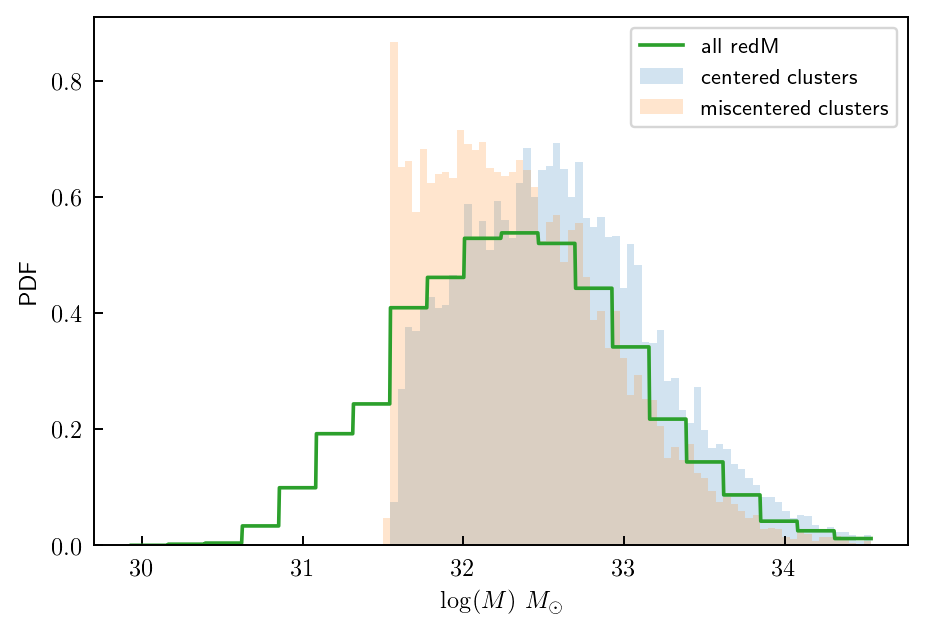

In [40]:
from tools.halo_mass_template import *
#Testing mass function
plt.figure(figsize=(6,4))
plt.hist(np.log(redM_cent.M200b), 100, (13*np.log(10), 15*np.log(10)), alpha=0.2, density=True, label='centered clusters')
plt.hist(np.log(redM_miscent.M200b), 100, (13*np.log(10), 15*np.log(10)), alpha=0.2, density=True, label='miscentered clusters')

lnM_arr = np.linspace(13*np.log(10), 15*np.log(10), 1000)
hmf_template, lnM_bin_cen = redMaPPer_hmf(lnM_arr)
#print hmf_template

plt.plot(lnM_arr, hmf_template, label='all redM')

plt.legend(fontsize=9)
plt.ylabel('PDF')
plt.xlabel(r'$\log(M)$~$M_\odot$ ')
plt.show()

### Extracting parameters

In [41]:
##Shorthand name for relevant halo/redM parameters
halos_ID_cent, q_cent, s_cent, cos_i_cent = read_shape_param(np.array(redM_cent), convcut=True)
richness = redM_cent.richness
halos_M  = redM_cent.M200b

print "Halo mass range is from ", min(np.log10(halos_M)), max(np.log10(halos_M))

Halo mass range is from  13.703395 15.356619


### Binning by cos(i) and richness

In [42]:
from repo.halo_shape.read_shape_param import halo_bin_stat

#Bin by cosine
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])
    
cosi_bins_ind_cent = halo_bin_stat(cos_i_cent, cosi_bins)
    
#Bin by richness
lmda_max = np.max(richness)
lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
num_lmda_bins = len(lmda_bins)
lmda_bins_ind_cent = halo_bin_stat(richness, lmda_bins)
print 'Maximum richness after cuts is ', lmda_max

#Contains all halos. List should be of length with an array that contains all halos.
all_ind = [np.arange(len(q_cent))]

Maximum richness after cuts is  303.044


In [43]:
#Binning richness by cos_i
num_bins = len(cosi_bins)
lnM200b_binned = [None]*num_bins
lnl_binned = [None]*num_bins

lnl = np.log(richness)
lnM200b = np.log(halos_M)

for i, cosi_bin in enumerate(cosi_bins):
    lnM200b_binned[i] = np.log(halos_M[cosi_bins_ind_cent[i]])
    lnl_binned[i] = np.log(richness[cosi_bins_ind_cent[i]])

### Generating tabulated hmf (for centered)

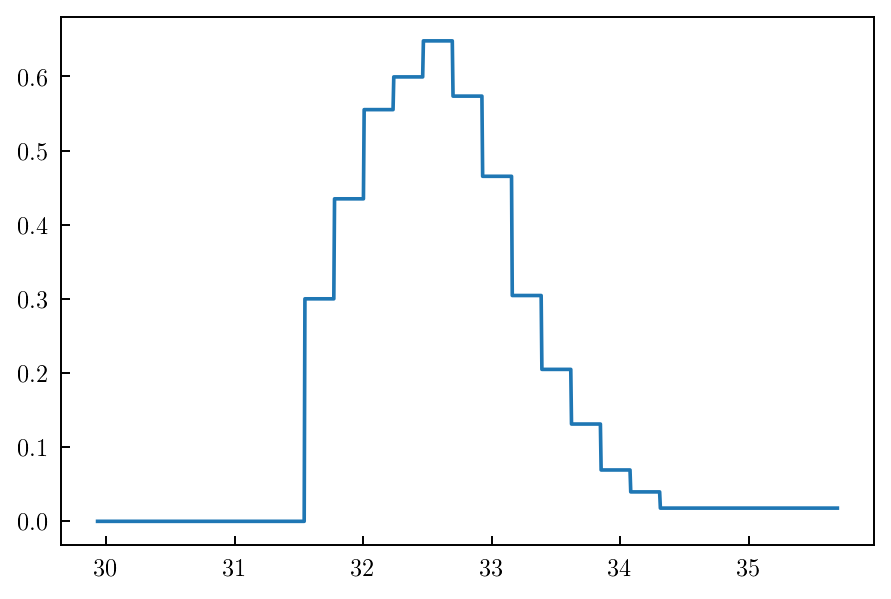

In [44]:
def input_hmf(lnM, lnM_min = 13*np.log(10), lnM_max=15*np.log(10), num_bins=20, lmda_bin=None):
    global lnM200b
    global lnM200b_binned
    
    lnM = np.array(lnM) #convert floats into array
    if len(np.shape(lnM))==0:
        lnM = lnM[np.newaxis]    
        
    if lmda_bin == None:
        hmf_lnM = lnM200b
    else:
        hmf_lnM = lnM200b_binned[lmda_bin]
    
    lnM_bin_edge = np.linspace(lnM_min, lnM_max, num_bins+1)   #.tolist()
    lnM_bin_cen = lnM_bin_edge[:-1] + (lnM_bin_edge[1] - lnM_bin_edge[0])/2.
    lnM_density = np.histogram(hmf_lnM, lnM_bin_edge, density=True)[0]    
    
    lnM_bin_num = np.array(np.searchsorted(lnM_bin_edge, lnM) - 1)
    lnM_bin_num[np.where(lnM_bin_num == -1)[0]] += 1 #for mass below smallest
    lnM_bin_num[np.where(lnM_bin_num == num_bins)[0]] -= 1 #for mass above highest 

    return lnM_density[lnM_bin_num], lnM_bin_cen

lnM_arr = np.linspace(13*np.log(10), 15.5*np.log(10), 1000)
hmf_cent, lnM_bin_cen  = input_hmf(lnM_arr)
plt.plot(lnM_arr, hmf_cent)

### Generating MCMC Chains

In [16]:
#MCMC chain setup
num=200
n_iter=num*3000
n_burn=num*200
n_thin=num    

'''
mcmc_filestr = range(len(cosi_bins))
#For binned by cos_i
for i in mcmc_filestr:
    print '\n Bin number ', i
    mcmc_folder = tpltdir  + 'p_lmda_cosi_'+str(mcmc_filestr[i])+'_model1_centered'
    cosi_bin_ind_cent = cosi_bins_ind_cent[i]
    M=pymc.Model(make_model(hmf_cent, lnl_binned[i], lnM200b_binned[i]))
    mc=MCMC(M, db='txt', dbname=mcmc_folder)
    mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)
'''

##For all 
mcmc_folder = tpltdir  + 'p_lmda_cosi_'+'all_'+'model1_centered'
M=pymc.Model(make_model(hmf_cent, lnl, lnM200b))
mc=MCMC(M, db='txt', dbname=mcmc_folder)
mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)

 [-----------------100%-----------------] 600000 of 600000 complete in 838.5 sec

## Running chains for miscentered clusters

In [17]:
##Shorthand name for relevant halo/redM parameters
halos_ID_miscent, q_miscent, s_miscent, cos_i_miscent = read_shape_param(np.array(redM_miscent), convcut=True)
richness = redM_miscent.richness
halos_M  = redM_miscent.M200b

print "Halo mass range is from ", min(np.log10(halos_M)), max(np.log10(halos_M))

Halo mass range is from  13.016825 15.531862


In [18]:
from repo.halo_shape.read_shape_param import halo_bin_stat

#Bin by cosine
cosi_num_bin = 5
cosi_bin_edge = np.linspace(0,1,cosi_num_bin+1)
cosi_bins = []
for i in range(cosi_num_bin):
    cosi_bins.append([cosi_bin_edge[i], cosi_bin_edge[i+1]])
    
cosi_bins_ind_miscent = halo_bin_stat(cos_i_miscent, cosi_bins)
    
#Bin by richness
lmda_max = np.max(richness)
lmda_bins = [[20,30],[30,50],[50,lmda_max]] #upper limit must match lower limit of next bin
num_lmda_bins = len(lmda_bins)
lmda_bins_ind_miscent = halo_bin_stat(richness, lmda_bins)
print 'Maximum richness after cuts is ', lmda_max

#Contains all halos. List should be of length with an array that contains all halos.
all_ind = [np.arange(len(q_miscent))]

Maximum richness after cuts is  247.15


In [19]:
#Binning richness by cos_i
num_bins = len(cosi_bins)
lnM200b_binned = [None]*num_bins
lnl_binned = [None]*num_bins

lnl = np.log(richness)
lnM200b = np.log(halos_M)

for i, cosi_bin in enumerate(cosi_bins):
    lnM200b_binned[i] = np.log(halos_M[cosi_bins_ind_miscent[i]])
    lnl_binned[i] = np.log(richness[cosi_bins_ind_miscent[i]])

### Generating tabulated hmf (for miscentered)

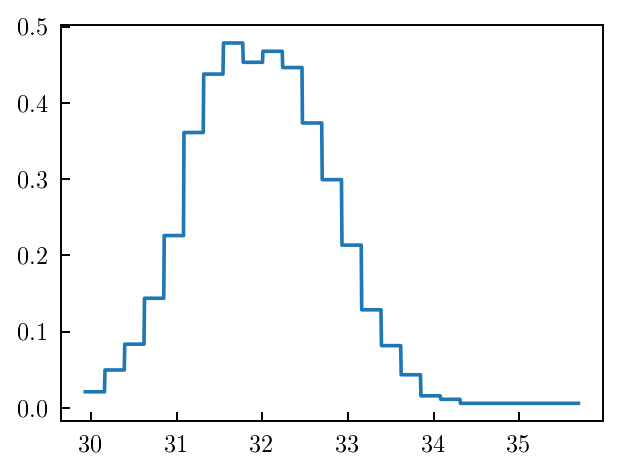

In [20]:
def input_hmf(lnM, lnM_min = 13*np.log(10), lnM_max=15*np.log(10), num_bins=20, lmda_bin=None):
    global lnM200b
    global lnM200b_binned
    
    lnM = np.array(lnM) #convert floats into array
    if len(np.shape(lnM))==0:
        lnM = lnM[np.newaxis]    
        
    if lmda_bin == None:
        hmf_lnM = lnM200b
    else:
        hmf_lnM = lnM200b_binned[lmda_bin]
    
    lnM_bin_edge = np.linspace(lnM_min, lnM_max, num_bins+1)   #.tolist()
    lnM_bin_cen = lnM_bin_edge[:-1] + (lnM_bin_edge[1] - lnM_bin_edge[0])/2.
    lnM_density = np.histogram(hmf_lnM, lnM_bin_edge, density=True)[0]    
    
    lnM_bin_num = np.array(np.searchsorted(lnM_bin_edge, lnM) - 1)
    lnM_bin_num[np.where(lnM_bin_num == -1)[0]] += 1 #for mass below smallest
    lnM_bin_num[np.where(lnM_bin_num == num_bins)[0]] -= 1 #for mass above highest 

    return lnM_density[lnM_bin_num], lnM_bin_cen

lnM_arr = np.linspace(13*np.log(10), 15.5*np.log(10), 1000)
hmf_miscent, lnM_bin  = input_hmf(lnM_arr)
plt.figure(figsize=(4,3))
plt.plot(lnM_arr, hmf_miscent)

### Generating MCMC Chains

In [21]:
#MCMC chain setup
num=200
n_iter=num*3000
n_burn=num*200
n_thin=num    

'''
mcmc_filestr = range(len(cosi_bins))
#For binned by cos_i
for i in mcmc_filestr:
    print '\n Bin number ', i
    mcmc_folder = tpltdir  + 'p_lmda_cosi_'+str(mcmc_filestr[i])+'_model1'+'_miscentered'
    cosi_bin_ind_miscent = cosi_bins_ind_miscent[i]
    M=pymc.Model(make_model(hmf_miscent, lnl_binned[i], lnM200b_binned[i]))
    mc=MCMC(M, db='txt', dbname=mcmc_folder)
    mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)
'''

##For all 
mcmc_folder = tpltdir  + 'p_lmda_cosi_'+'all_'+'model1_miscentered'
M=pymc.Model(make_model(hmf_miscent, lnl, lnM200b))
mc=MCMC(M, db='txt', dbname=mcmc_folder)
mc.sample(iter=n_iter, burn=n_burn, thin=n_thin)

 [-----------------100%-----------------] 600000 of 600000 complete in 1003.1 sec

## Comparison of posteriors

In [24]:
from scipy.stats import sem
c_cent = ChainConsumer() #contains multiple chains across different models

### For centered

In [25]:
mcmc_folder = tpltdir + 'p_lmda_cosi_'+'all_'+'model1_centered'
        
As=np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
Bs=np.genfromtxt(mcmc_folder+'/Chain_0/B.txt')
sig0s=np.genfromtxt(mcmc_folder+'/Chain_0/sigma0.txt')

# plot the parameter constraints
data=np.vstack( (As, Bs, sig0s) ).T
c_cent.add_chain(data, parameters=[r"$A$", r"$B$", r"$\sigma_0$"], \
                name=r'Model1 centered')
c_cent.configure(statistics="max_shortest")
c_cent = c_cent.analysis.get_summary()



### For miscentered

In [26]:
c_miscent = ChainConsumer()

In [27]:
mcmc_folder = tpltdir + 'p_lmda_cosi_'+'all_'+'model1_miscentered'
        
As=np.genfromtxt(mcmc_folder+'/Chain_0/A.txt')
Bs=np.genfromtxt(mcmc_folder+'/Chain_0/B.txt')
sig0s=np.genfromtxt(mcmc_folder+'/Chain_0/sigma0.txt')

# plot the parameter constraints
data=np.vstack( (As, Bs, sig0s) ).T
c_miscent.add_chain(data, parameters=[r"$A$", r"$B$", r"$\sigma_0$"], \
                name=r'Model1 miscentered')
c_miscent.configure(statistics="max_shortest")
c_miscent = c_miscent.analysis.get_summary()



### Plotting results

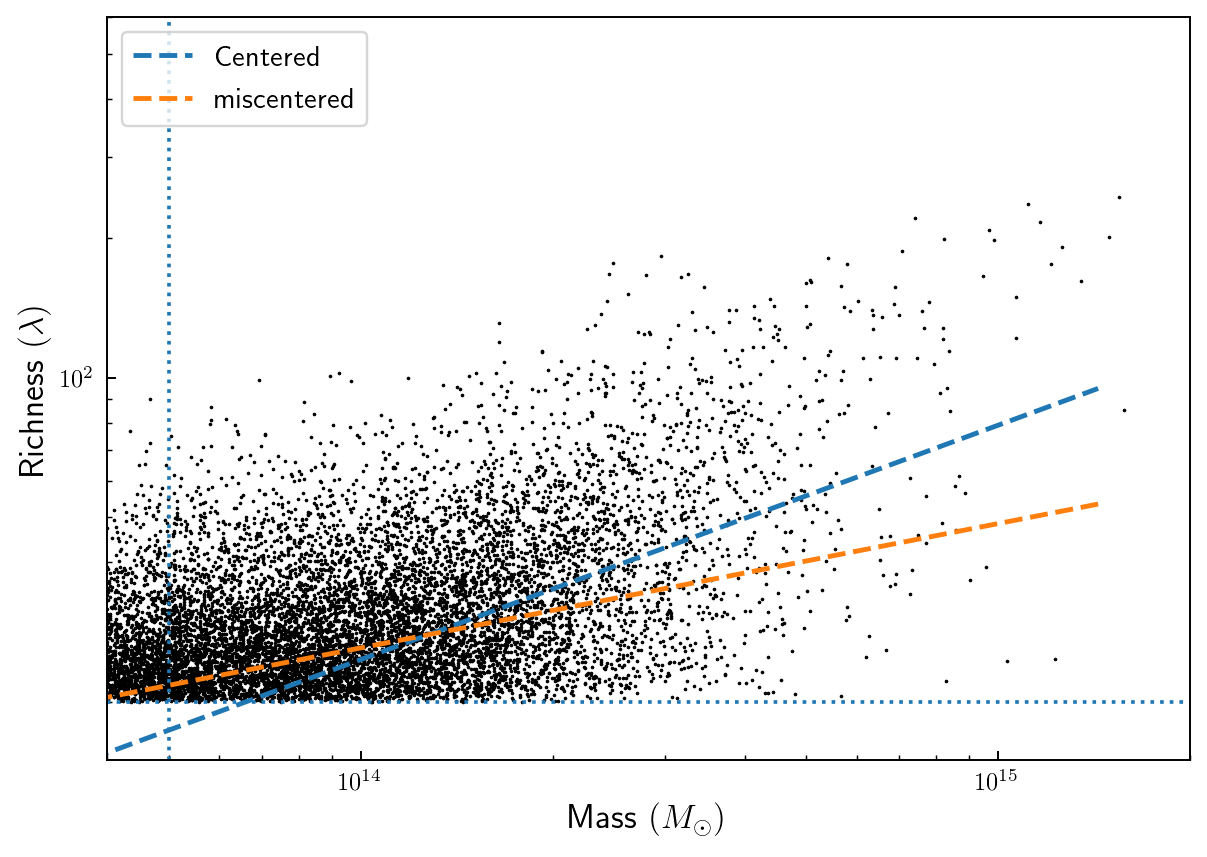

In [35]:
#Posterior likelihoods
lnA_post_model1_cent = np.zeros(3)
B_post_model1_cent = np.zeros(3)
sig0_post_model1_cent = np.zeros(3)

lnA_post_model1_miscent = np.zeros(3)
B_post_model1_miscent = np.zeros(3)
sig0_post_model1_miscent = np.zeros(3)


#For centered
lnA_post_model1_cent = np.log(c_cent["$A$"])
B_post_model1_cent = c_cent["$B$"]
sig0_post_model1_cent = c_cent["$\sigma_0$"]

lnA_post_model1_miscent = np.log(c_miscent["$A$"])
B_post_model1_miscent = c_miscent["$B$"]
sig0_post_model1_miscent = c_miscent["$\sigma_0$"]


#x parameters are the mean of each cosi_bin
#Plot the trendlines for different bins
fig, axs = plt.subplots(1 ,1, tight_layout=True, figsize=(7,5))
axs.plot(halos_M, richness, 'k.', markersize=1)

lnM_range = np.arange(31,35,0.1)
#For centered
i=0
lnA_cosi_maxL = lnA_post_model1_cent[1]; 
B_cosi_maxL = B_post_model1_cent[1];
sig0_cosi_maxL = sig0_post_model1_cent[1]
mu_lnl_model = lnA_cosi_maxL + B_cosi_maxL*(lnM_range-np.log(10)*14)
sig_lnl_model=np.sqrt(sig0_cosi_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))
axs.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), linewidth=2, linestyle='dashed', \
        label='Centered'.format(cosi_bin_min,cosi_bin_max))

#For miscentered
lnA_cosi_maxL = lnA_post_model1_miscent[1]; 
B_cosi_maxL = B_post_model1_miscent[1];
sig0_cosi_maxL = sig0_post_model1_miscent[1]
mu_lnl_model = lnA_cosi_maxL + B_cosi_maxL*(lnM_range-np.log(10)*14)
sig_lnl_model=np.sqrt(sig0_cosi_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))
axs.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), linewidth=2, linestyle='dashed', \
        label='miscentered'.format(cosi_bin_min,cosi_bin_max))
             

axs.axhline(20, linestyle='dotted')
axs.axvline(5e13, linestyle='dotted')
axs.set_yscale('log')
axs.set_xscale('log')
axs.legend(loc='upper left', fontsize=12)
axs.set_xlabel('Mass $(M_\odot)$',fontsize=14)
axs.set_ylabel('Richness $(\lambda)$',fontsize=14)
axs.set_ylim((15,600))
axs.set_xlim((4e13,2e15))




#axs.axvspan(2.05e14, 2.13e14, alpha=0.5)
#axs.axhline(40)
#plt.savefig('mass_richness_cosibinned_60718.png')

plt.show()


In [ ]:
#Posterior. For each paramater array contains 3 indexes -- low, max posterior, and high range. 
'''
funk = c_posterior[i]["$A$"] reads the A parameter statistic of the i-th chain. 
The statistic is read as array of min, mean, max values of statistic (e.g. max_shhortest),
so that funk[1], for instance,  is the mean value of A in the ith chain. 
'''

#x parameters are the mean of each cosi_bin
x_pos = np.zeros(len(cosi_bins))
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    x_pos[i] = (cosi_bin_max+cosi_bin_min)/2.
#print x_pos

#Posterior likelihoods
lnA_post_model1_cent = np.zeros((len(cosi_bins),3))
B_post_model1_cent = np.zeros((len(cosi_bins),3))
sig0_post_model1_cent = np.zeros((len(cosi_bins),3))

lnA_post_model1_miscent = np.zeros((len(cosi_bins),3))
B_post_model1_miscent = np.zeros((len(cosi_bins),3))
sig0_post_model1_miscent = np.zeros((len(cosi_bins),3))


#For centered
for i in range(0,5):
    lnA_post_model1_cent[i] = np.log(c_cent[i]["$A$"])
    B_post_model1_cent[i] = c_cent[i]["$B$"]
    sig0_post_model1_cent[i] = c_cent[i]["$\sigma_0$"]

'''
#For miscentered
for i in range(0,5):
    lnA_post_model1_miscent[i] = np.log(c_miscent[i]["$A$"])
    B_post_model1_miscent[i] = c_miscent[i]["$B$"]
    sig0_post_model1_miscent[i] = c_miscent[i]["$\sigma_0$"]
'''

#Plotting the posteriors #########################################################
#Plotting posterior for lnA
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(8,3))
subtitles = [r'$\log(A)$', r'$B$', r'$\sigma_0$']
stat_name = ["$A$", "$B$", "$\sigma_0$"]

#posterior for A
axs[0].errorbar(x_pos, lnA_post_model1_cent[:,1], \
                yerr=[lnA_post_model1_cent[:,1]-lnA_post_model1_cent[:,0], \
                      lnA_post_model1_cent[:,2]-lnA_post_model1_cent[:,1]], \
                linewidth=0.6, marker='o',markersize=3, label='centered')

axs[0].errorbar(x_pos, lnA_post_model1_miscent[:,1], \
                yerr=[lnA_post_model1_miscent[:,1]-lnA_post_model1_miscent[:,0], \
                      lnA_post_model1_miscent[:,2]-lnA_post_model1_miscent[:,1]], \
                linewidth=0.6, marker='o',markersize=3, label='miscentered') 

#posterior for B
axs[1].errorbar(x_pos, B_post_model1_cent[:,1], \
                yerr=[B_post_model1_cent[:,1]-B_post_model1_cent[:,0], \
                      B_post_model1_cent[:,2]-B_post_model1_cent[:,1]], \
                linewidth=0.6, marker='o',markersize=3, label='centered')

axs[1].errorbar(x_pos, B_post_model1_miscent[:,1], \
                yerr=[B_post_model1_miscent[:,1]-B_post_model1_miscent[:,0], \
                      B_post_model1_miscent[:,2]-B_post_model1_miscent[:,1]], \
                linewidth=0.6, marker='o',markersize=3, label='miscentered') 


#posterior for sigma0
axs[2].errorbar(x_pos, sig0_post_model1_cent[:,1], \
                yerr=[sig0_post_model1_cent[:,1]-sig0_post_model1_cent[:,0], \
                      sig0_post_model1_cent[:,2]-sig0_post_model1_cent[:,1]], \
                linewidth=0.6, marker='o',markersize=3, label='centered')

axs[2].errorbar(x_pos, sig0_post_model1_miscent[:,1], \
                yerr=[sig0_post_model1_miscent[:,1]-sig0_post_model1_miscent[:,0], \
                      sig0_post_model1_miscent[:,2]-sig0_post_model1_miscent[:,1]], \
                linewidth=0.6, marker='o',markersize=3, label='miscentered') 
                      
                      

for i in range(3):
    axs[i].set_xlim((0,1))
    axs[i].set_xticks(x_pos)
    axs[i].set_ylabel(subtitles[i], size=14)
    axs[i].set_xlabel(r'$\cos(i)$', size=14) 

axs[2].set_xlabel(r'$\cos(i)$', size=14) 
axs[0].legend(fontsize=10)
#plt.savefig('richness_mass_modelparams_cosibinned_060718.png')
plt.show()

### Trendlines


In [ ]:
#Plot the trendlines for different bins
fig, axs = plt.subplots(1 ,1, tight_layout=True, figsize=(7,5))
axs.plot(halos_M, richness, 'k.', markersize=1)

lnM_range = np.arange(31,35,0.1)
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    lnA_cosi_maxL = lnA_post_model1_cent[i,1]; 
    B_cosi_maxL = B_post_model1_cent[i,1];
    sig0_cosi_maxL = sig0_post_model1_cent[i,1]
    mu_lnl_model = lnA_cosi_maxL + B_cosi_maxL*(lnM_range-np.log(10)*14)
    sig_lnl_model=np.sqrt(sig0_cosi_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))
    axs.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), linewidth=2, linestyle='dashed', \
        label='$\cos(i) \in [{:.1f}, {:.1f})$'.format(cosi_bin_min,cosi_bin_max))
             

axs.axhline(20, linestyle='dotted')
axs.axvline(5e13, linestyle='dotted')
axs.set_yscale('log')
axs.set_xscale('log')
axs.legend(loc='upper left', fontsize=12)
axs.set_xlabel('Mass $(M_\odot)$',fontsize=14)
axs.set_ylabel('Richness $(\lambda)$',fontsize=14)
axs.set_ylim((15,600))
axs.set_xlim((4e13,2e15))

'''
#Add an inset to show difference between lines
a = plt.axes([0.62, 0.2, .3, .3])
for i, cosi_bin in enumerate(cosi_bins):
    cosi_bin_min = cosi_bin[0]; cosi_bin_max = cosi_bin[1]
    lnA_cosi_maxL = lnA_post_model3[i,1]; 
    mu_lnl_model = lnA_cosi_maxL + B_cosi_maxL*(lnM_range-np.log(10)*14)
    sig_lnl_model=np.sqrt(sig0_cosi_maxL**2+(np.exp(mu_lnl_model)-1)/(np.exp(2*mu_lnl_model)))
    plt.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), linewidth=2, linestyle='dashed', alpha=1)
plt.plot(10**(lnM_range/np.log(10)), np.exp(mu_lnl_model), label='Combined', linewidth=2)
#plt.plot(halos_M, richness, 'k.', markersize=2)
plt.yscale('log'); plt.xscale('log')
plt.xlim((2.2e14, 3e14)); plt.ylim((47,60))   
plt.xticks((2.2e14, 3e14), (r'$2.2 \times 10^{14}$', r'$3 \times 10^{14}$'))
#plt.yticks([])
'''

#axs.axvspan(2.05e14, 2.13e14, alpha=0.5)
#axs.axhline(40)
#plt.savefig('mass_richness_cosibinned_60718.png')

plt.show()

## Shape information

In [ ]:
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize=(3,3))
num_bin = np.linspace(0.0,1.0,15)

####Centered halos########
lmda_bin_num = len(lmda_bins_ind_cent)
weights_cent = np.ones_like(q_cent, dtype=float)/len(q_cent)* 100
axs.hist(cos_i_cent, num_bin, density=False, fill=False, weights=weights_cent, histtype='step', label="Centered") 


####miscentered halos########
lmda_bin_num = len(lmda_bins_ind_miscent)
weights_miscent = np.ones_like(q_miscent, dtype=float)/len(q_miscent)* 100
axs.hist(cos_i_miscent, num_bin, density=False, fill=False, weights=weights_miscent, histtype='step', label="miscentered") 

#axs.set_ylim((0,60))
axs.legend(loc='upper left', fontsize=12, frameon=False)

axs.set_xlabel(r'$\cos{i}$', size=15)
axs.set_ylabel('$p(\cos{i})$', size=15)
plt.show()
    